# Poisson equation

$$ -\varepsilon_0 \Delta \phi = \rho$$

Also we want to fix the potential at the boundaries:
$$\phi|_{\partial\Omega} = g$$
Choose units such that $\varepsilon_0 = 1$ .

Variational formulation:

### Step 1:
Integrate against test functions
$$ \int -\Delta(\phi) \cdot v  = \int \rho \cdot v $$
for all test functions $v$. Tricky to build stable FEM using this formulation. Need to find an easier formulation.
### Step 2: 
Bring down the differentiation orders:
$$ \int \nabla(\phi) \cdot \nabla(v)  = \int \rho \cdot v $$

In [1]:
from fenics import *
mesh = IntervalMesh(10, -1.0, 1.0)
V = FunctionSpace(mesh, "P", 1)
v = TestFunction(V)
phi = Function(V)
rho = Constant(1.0)
g = Constant(0.0)

F = inner(grad(phi), grad(v)) * dx - inner(rho, v) * dx
bc = DirichletBC(V, g, "on_boundary")

solve(F == 0, phi, bc)
plot(phi)

# What about the electic field?

$$ -\nabla \phi = E$$
$$ \varepsilon_0 div(E) = \rho$$
$$\phi|_{\partial\Omega} = g$$
Choose units such that $\varepsilon_0 = 1$ . Variational formulation:

### Step 1:
Integrate against test functions
$$ \int -\nabla(\phi) \cdot v_E  = \int E \cdot v_E $$
$$ \int div(E) \cdot v_{\phi} = \int \rho \cdot v_{\phi}$$
for all test functions $v_E, v_{\phi}$.
### Step 2: 
Single equation

$$\int -\nabla(\phi)\cdot v_E - \int E \cdot v_E + \int div(E) \cdot v_{\phi} = \int \rho \cdot v_{\phi}$$



L2 error phi: 0.06773251497099789
L2 error E  : 0.03672482195174655


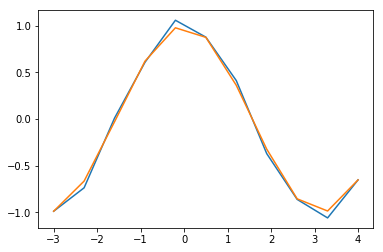

In [2]:
from fenics import *

mesh = IntervalMesh(10, -3, 4)
cell = mesh.ufl_cell()

el_phi = FiniteElement("CG", cell, 1)
el_E   = VectorElement("CG", cell, 1)

el = MixedElement([el_phi, el_E])
V  = FunctionSpace(mesh, el)
v_phi, v_E = TestFunctions(V)
phi, E = TrialFunctions(V)

V_phi = V.sub(0)
V_E   = V.sub(1)

deg = 2
phi_exact = Expression("cos(x[0])", degree=deg)
E_exact   = Expression(("sin(x[0])",), degree=deg)
rho       = Expression("cos(x[0])", degree=deg)

bc = DirichletBC(V_phi, phi_exact, "on_boundary")

A = inner(-grad(phi), v_E)*dx - inner(E, v_E)*dx + inner(div(E),  v_phi)*dx
f = inner(rho, v_phi)*dx

u = Function(V)
solve(A == f, u, bcs=bc)

phi, E = u.split()

print(f"L2 error phi: {errornorm(phi_exact, phi, 'L2', mesh=mesh)}")
print(f"L2 error E  : {errornorm(E_exact  , E  , 'L2', mesh=mesh)}")
plot(phi)
plot(phi_exact, mesh=mesh)

# 2d

relerror phi: 0.0013224487761955754
relerror E  : 0.005498979679208352


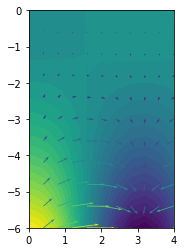

In [3]:
from fenics import *

mesh = RectangleMesh(Point(0, -6), Point(4, 0), 10, 10)
cell = mesh.ufl_cell()

# stable? + good E?
el_phi = FiniteElement("CG", cell, 2)
el_E   = VectorElement("CG", cell, 2)

# # instable
# el_phi = FiniteElement("DG", cell, 2)
# el_E   = FiniteElement("BDM",cell, 1)

# # stable
# el_phi  = FiniteElement("CG", cell, 3)
# el_E = FiniteElement("DRT", cell, 2)

el = MixedElement([el_phi, el_E])
V  = FunctionSpace(mesh, el)
v_phi, v_E = TestFunctions(V)
phi, E = TrialFunctions(V)

V_phi = V.sub(0)
V_E   = V.sub(1)

deg = 2

phi_exact = Expression("cos(x[0])*x[1]*x[1]", degree=deg)
E_exact   = Expression(("sin(x[0])*x[1]*x[1]",  "-cos(x[0])*2*x[1]"), degree=deg)
rho       = Expression("cos(x[0])*x[1]*x[1] - cos(x[0])*2", degree=deg)

bc = DirichletBC(V_phi, phi_exact, "on_boundary")

A = inner(-grad(phi), v_E)*dx - inner(E, v_E)*dx + inner(E, -grad(v_phi))*dx
f = inner(rho, v_phi)*dx

u = Function(V)
solve(A == f, u, bcs=bc)

phi, E = u.split()

def relerror(phi_exact, phi, mesh):
    scale = norm(phi_exact, "L2", mesh=mesh)
    return errornorm(phi_exact, phi, "L2", mesh=mesh)/scale

# print("Condition Number: {}".format(np.linalg.cond(M.array())))
print(f"relerror phi: {relerror(phi_exact, phi, mesh=mesh)}")
print(f"relerror E  : {relerror(E_exact  , E  , mesh=mesh)}")
# plot(phi)
plot(rho, mesh=mesh)
plot(E)

# More fancy geometry

In [4]:
from fenics import *

class Poisson(object):
    def __init__(self,
                 mesh,
                ):
        self.mesh = mesh
        cell = mesh.ufl_cell()
        el_phi = FiniteElement("CG", cell, 2)
        el_E   = VectorElement("CG", cell, 2)
        
        el = MixedElement([el_phi, el_E])
        self.V  = FunctionSpace(mesh, el)
        
        self.V_phi = self.V.sub(0)
        self.V_E   = self.V.sub(1)
        
        dim = mesh.geometric_dimension()
        deg = 2
        if dim == 1:
            self.phi_exact = Expression("cos(x[0])", degree=deg)
            self.E_exact   = Expression(("sin(x[0])",), degree=deg)
            self.rho       = Expression("cos(x[0])", degree=deg)
        elif dim == 2:
            self.phi_exact = Expression("cos(x[0])*x[1]*x[1]", degree=deg)
            self.E_exact   = Expression(("sin(x[0])*x[1]*x[1]",  "-cos(x[0])*2*x[1]"), degree=deg)
            self.rho       = Expression("cos(x[0])*x[1]*x[1] - cos(x[0])*2", degree=deg)
        elif dim == 3:
            self.phi_exact = Expression("cos(x[0])*x[1]*x[1]*x[2]", degree=deg)
            self.E_exact   = Expression((
                "sin(x[0])*x[1]*x[1]*x[2]",  
                "-cos(x[0])*2*x[1]*x[2]",
                "-cos(x[0])*x[1]*x[1]"
                ), degree=deg)
            self.rho       = Expression("cos(x[0])*x[1]*x[1]*x[2] - cos(x[0])*2*x[2]", degree=deg)
        else:
            raise Exception(f"Invalid geometric dimension: {dim}")
    
    def build(self):
        phi, E = TrialFunctions(self.V)
        v_phi, v_E = TestFunctions(self.V)
        
        self.bc = DirichletBC(self.V_phi, self.phi_exact, "on_boundary")
        self.A = inner(-grad(phi), v_E)*dx - inner(E, v_E)*dx + inner(E, -grad(v_phi))*dx
        self.f = inner(self.rho, v_phi)*dx
        self.solution = Function(self.V)
        return self
        
    def solve(self):
        solve(self.A == self.f, self.solution, bcs=self.bc)
        phi, E = self.solution.split()
        self.phi = phi
        self.E = E
        return self
    
    def run(self):
        self.build()
        self.solve()
        print(f"relerror phi: {self.relerror(self.phi_exact, self.phi)}")
        print(f"relerror E  : {self.relerror(self.E_exact  , self.E  )}")
        return self
        
    def relerror(self, phi_exact, phi):
        scale = norm(phi_exact, "L2", mesh=self.mesh)
        return errornorm(phi_exact, phi, "L2", mesh=self.mesh)/scale
    
    def save(self, directory):
        import os
        if not os.path.exists(directory):
            os.makedirs(directory)
        File(os.path.join(directory, "E.pvd")) << self.E
        File(os.path.join(directory, "phi.pvd")) << self.phi
        return self
        
    
    def plot(self, mesh=True, rho=True, phi=False, E=True):
        if mesh:
            plot(self.mesh)
        if rho:
            plot(self.rho, mesh=self.mesh)
        if E:
            plot(self.E)
        if phi:
            plot(self.phi)
        return self

relerror phi: 6.324310557499288e-06
relerror E  : 0.00033008324771670186


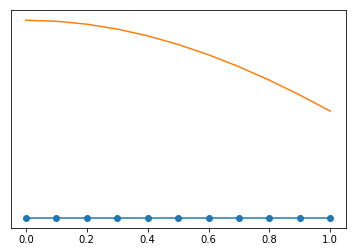

In [5]:
mesh = UnitIntervalMesh(10)
Poisson(mesh).run().plot(E=False)

relerror phi: 5.4360314618917203e-05
relerror E  : 0.0009285734208366882


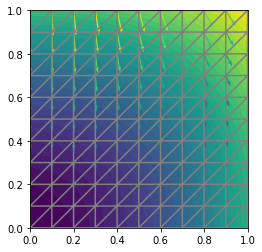

In [6]:
mesh = UnitSquareMesh(10,10)
Poisson(mesh).run().plot()

relerror phi: 0.0016394664592247468
relerror E  : 0.011578914695902637


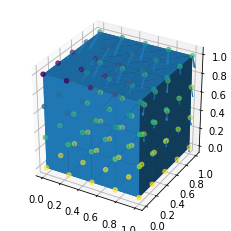

In [7]:
mesh = UnitCubeMesh(4,4,3)
obj = Poisson(mesh).run().plot()

In [8]:
import mshr
from fenics import *

r_outer = 2
r_inner = 0.5
height  = 4
y0 = -3
rect_outer = mshr.Rectangle(Point(-r_outer, y0), Point(r_outer, y0+height))
rect_inner = mshr.Rectangle(Point(-r_inner, y0), Point(r_inner, y0+height))

circ_outer = mshr.Circle(Point(0, y0+height), r_outer)
circ_inner = mshr.Circle(Point(0, y0+height), r_inner)

geo = rect_outer + circ_outer - rect_inner - circ_inner
mesh = mshr.generate_mesh(geo, 10)
mesh

relerror phi: 0.0009803751450693776
relerror E  : 0.005552483098550265


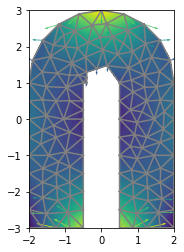

In [9]:
Poisson(mesh).run().plot()

In [10]:
import mshr
from fenics import *
r_outer = 2
r_inner = 1
height  = 4
z0 = -3

cyl_outer = mshr.Cylinder(Point(0, 0, z0), Point(0, 0, z0+height), r_outer, r_outer)
cyl_inner = mshr.Cylinder(Point(0, 0, z0), Point(0, 0, z0+height), r_inner, r_inner)
# adding the dome makes the computer hang
# sph_outer = mshr.Sphere(Point(0,0,z0+height), r_outer)
# sph_inner = mshr.Sphere(Point(0,0,z0+height), r_inner)
# geo = cyl_outer + sph_outer - sph_inner - cyl_inner 
geo = cyl_outer - cyl_inner
mesh = mshr.generate_mesh(geo, 1)
mesh


relerror phi: 0.01057652097779264
relerror E  : 0.042338193272244216


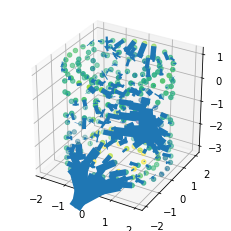

In [11]:
Poisson(mesh).run().save("poisson3d").plot(mesh=False)